# LDA (Latent Dirichlet Allocation) & LSI (Latent Semantic Indexing)

#### Set parameters for how final model results will be saved

In [1]:
tokenized_run_name = "weighted_1_tokens"  #manually input the filename (no extension) to be used as input

In [2]:
data_directory = "../data/"

In [3]:
base_model_type = "lda_lds"
model_name_suffix = ""  #default should be blank; use to make not of any other mods
run_number = 1

In [4]:
final_model_name = f"{base_model_type}_{tokenized_run_name[:-7]}_run{run_number}{model_name_suffix}"

#### Imports

In [5]:
# general use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # for LDA modeling & presentation
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# # for LSA modeling
from sklearn.decomposition import TruncatedSVD

# for progress bar on loops
from tqdm import tqdm

#### Read in Dataframe with tokenized text

In [6]:
df = pd.read_csv(f"{data_directory}{tokenized_run_name}.csv")
df.head()

,name,href,tokenized_text
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...


In [7]:
df.isna().sum()

name              0
href              0
tokenized_text    0
dtype: int64

In [8]:
df.fillna("",inplace=True)

#### Count Vectorization & TfIDF

In [9]:
# Function draws heavily from Jiamei Wang's code: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def make_tfidf(input_df, text_colname='tokenized_text'):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        
    OUTPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    docs_raw = input_df[text_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    cvec = CountVectorizer(strip_accents = 'unicode',
                            stop_words = 'english',
                            lowercase = True,
                            token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                            max_df = 0.5,                        # discard words that appear in > 50% of the reviews
                            min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**cvec.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} non-unique words in {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], text_colname, dtm_tfidf.shape[1]))
    
    # return tf_vectorizer, tfidf_vectorizer, dtm_tfidf
    return tfidf_vectorizer, dtm_tfidf

In [10]:
tfidf_vectorizer, dtm_tfidf = make_tfidf(df, 'tokenized_text')

d:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2070: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


The shape of the tfidf is (2484, 16765), meaning that there are 2484 non-unique words in tokenized_text and 16765 tokens made through the filtering process.


#### Grid Search for best LDA model

In [11]:
# Define Grid Search Parameters
search_params = {'n_components': [5, 10, 20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

In [12]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_gridsearch(dtm_tfidf, search_params):
    '''
    INPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        model_gs - the GridSearchCV object
        best_lda_model - the best model, as determined by the grid search
    '''

    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model_gs = GridSearchCV(lda, param_grid=search_params, n_jobs=8, verbose=3)

    # Do the Grid Search
    model_gs.fit(dtm_tfidf)

    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model_gs.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model_gs.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model_gs.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))

    return model_gs, best_lda_model

In [13]:
model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Model Log Likelihood Score:  -65947.41918009132
Model Perplexity:  22268.069193725543


#### Plotting LDA model performance

In [14]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_plot_performance(model_gs, search_params):
    ''' 
    INPUTS:
        model_gs - the GridSearchCV object
        
    OUTPUTS:
        A graph comparing LDA Model Performance Scores with different params
    '''

    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelihoods from Grid Search Output
    gscore=model_gs.cv_results_

    log_likelihoods = {}
    for i in search_params['learning_decay']:
        log_likelihoods[i] = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==i]

    # Show graph
    plt.figure(figsize=(12, 8))
    for i in log_likelihoods:
        plt.plot(search_params['n_components'], log_likelihoods[i], label=i)
 
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelihood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return

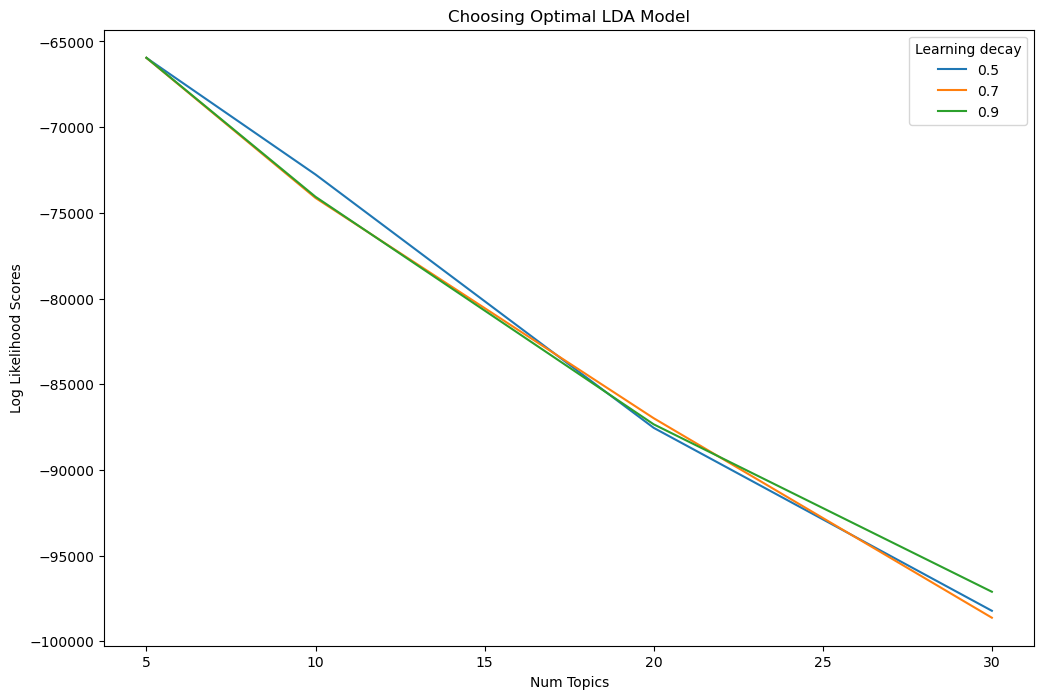

In [15]:
lda_plot_performance(model_gs, search_params)

#### (optional) Combined function for creating "best" LDA model with performance plot

In [16]:
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for more convenient parameter tuning)
# Once tuned/optimized, all 3 sub-functions can be run together in one command, wholly recreating the method used in the source referenced above

def optimal_lda_model(input_df, text_colname, search_params):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        best_lda_model - the best model, as determined by the grid search
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    
    tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
    model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)
    lda_plot_performance(model_gs, search_params)

    return best_lda_model, dtm_tfidf, tfidf_vectorizer

In [17]:
# (Same as above, in one single function call)

# best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(df, 'combined_text', search_params)

#### Force evaluate with different parameters

In [18]:
# Define Grid Search Parameters
search_params2 = {'n_components': [20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 20}
Model Log Likelihood Score:  -86010.98897164062
Model Perplexity:  83927.18200687072


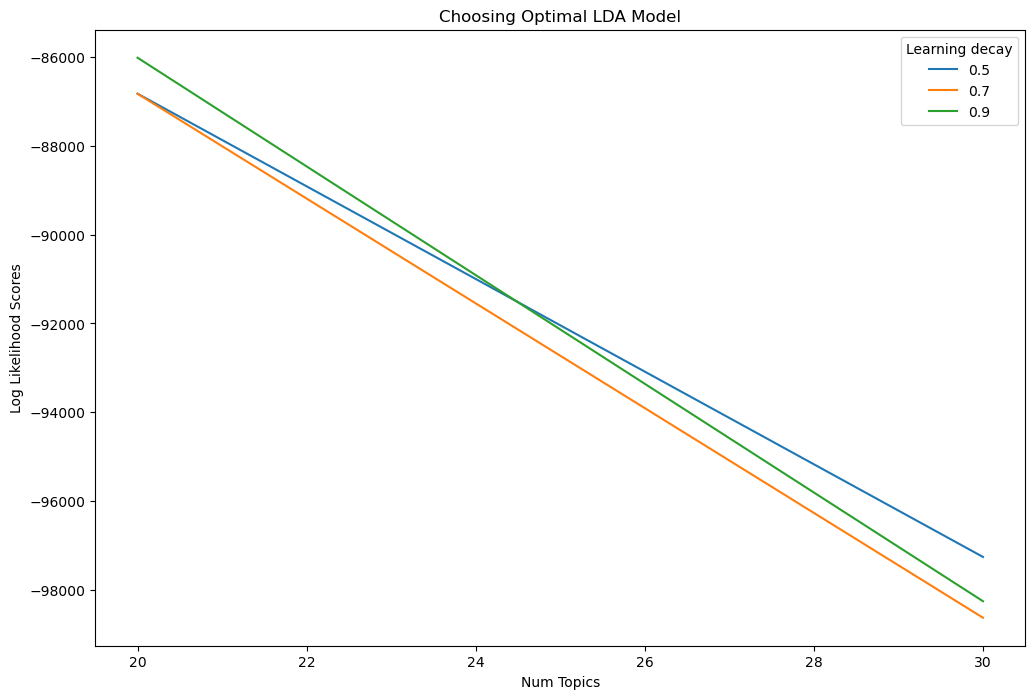

In [19]:
# tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
model_gs2, best_lda_model2 = lda_gridsearch(dtm_tfidf, search_params2)
lda_plot_performance(model_gs2, search_params2)

#### Display topic keywords & weights

In [20]:
# Function excerpted directly with no additional modifications from: (Jiamei Wang)
# https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08

#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display
    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in tqdm(enumerate(model.components_)):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


In [21]:
display_topics(best_lda_model, tfidf_vectorizer.get_feature_names_out(), n_top_words = 30) 

5it [00:00, 491.93it/s]


,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,kim,6.4,comedy,175.2,euphoria,1.1,municipality,0.2,naruto,0.2
1,jung,6.0,crime,151.8,leftover,0.2,hui,0.2,municipality,0.2
2,soo,5.7,action,115.8,salmon,0.2,seol,0.2,hui,0.2
3,hee,5.0,animation,111.5,athletes,0.2,hostages,0.2,seol,0.2
4,jin,4.9,adventure,108.6,beetle,0.2,pension,0.2,hostages,0.2
5,min,4.9,mystery,103.7,compilations,0.2,naruto,0.2,pension,0.2
6,korean,4.8,romance,84.3,comparable,0.2,eui,0.2,eui,0.2
7,yoon,4.7,documentary,74.8,trees,0.2,raped,0.2,raped,0.2
8,hyun,4.6,fantasy,69.9,usher,0.2,automotive,0.2,automotive,0.2
9,joon,4.1,thriller,64.3,grapple,0.2,shim,0.2,shim,0.2


#### Visualizing LDA output with the pyLDAvis library

In [22]:
# Topic Modelling Visualization for the show description texts
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.097894  0.000212       1        1  92.926763
0      0.033370  0.002131       2        1   2.212230
2      0.021549 -0.001086       3        1   1.622031
4      0.021487 -0.000625       4        1   1.619488
3      0.021489 -0.000631       5        1   1.619488, topic_info=              Term       Freq      Total Category  logprob  loglift
8331           kim   7.000000   7.000000  Default  30.0000  30.0000
8622           lee  10.000000  10.000000  Default  29.0000  29.0000
8410        korean   3.000000   3.000000  Default  28.0000  28.0000
10926         park   9.000000   9.000000  Default  27.0000  27.0000
8038           jin   2.000000   2.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
8203         kanye   0.026974   0.635178   Topic5  -9.7268   0.9640
11451    portfolio   0.026974   0.469784   Topic5  -9.7268   1.2657
16329      webtoon   0.026974   0.576253   Topic5  -9.7268   1.0614
15160       thrice   0.026973   0.405228   Topic5  -9.7268   1.4135
759    appreciated   0.026973   0.472594   Topic5  -9.7268   1.2597

[283 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
139        1  1.002464     action
142        1  0.901942     active
245        1  1.002320  adventure
397        1  0.861459     albums
631        1  0.998341  animation
...      ...       ...        ...
16622      1  0.753853   wrestler
16623      1  0.679195  wrestling
16679      2  1.183431       yeon
16692      2  1.011482        yoo
16693      2  0.869803       yoon

[112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

#### Generate results (fit-transorm) from a LDA model and tfidf matrix

In [23]:
lda_results = best_lda_model.fit_transform(dtm_tfidf) 

#### Append the LDA topic % matches onto the results dataframe

In [24]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lda_topic_pct_cols(lda_results, df_to_append_to):
    
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lda_results[j]):
            df_to_append_to.loc[j, f"lda_topic{i}_match_pct"] = topic
    return
        

In [25]:
make_lda_topic_pct_cols(lda_results, df)

100%|██████████| 2484/2484 [00:00<00:00, 3623.92it/s]


In [26]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.008706,0.008706,0.008706,0.965158,0.008724
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.011398,0.011398,0.011398,0.954373,0.011431
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.013696,0.013696,0.013696,0.945215,0.013696
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.009460,0.009460,0.009460,0.962160,0.009460
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.015673,0.015673,0.015673,0.937274,0.015707


In [27]:
df.shape

(2484, 8)

# LSA model

In [28]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/


# Define the number of topics or components
num_components=10

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa_results = lsa.fit_transform(dtm_tfidf)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

In [29]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/

# Print the topics with their terms

def lsa_topics_out(tfidf_vectorizer, svd_object):
    terms = tfidf_vectorizer.get_feature_names_out()

    for index, component in enumerate(svd_object.components_):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
        top_terms_list=list(dict(top_terms_key).keys())
        print("Topic "+str(index)+": ",top_terms_list)

    return

In [30]:
lsa_topics_out(tfidf_vectorizer, lsa)

Topic 0:  ['comedy', 'crime', 'animation', 'action', 'adventure', 'mystery', 'romance', 'documentary', 'fantasy', 'thriller']
Topic 1:  ['crime', 'mystery', 'documentary', 'thriller', 'biography', 'horror', 'detective', 'history', 'police', 'murder']
Topic 2:  ['comedy', 'romance', 'abc', 'seasons', 'sitcom', 'reality', 'guest', 'school', 'talk', 'renew']
Topic 3:  ['documentary', 'biography', 'history', 'crime', 'comedy', 'animation', 'sport', 'war', 'anime', 'planet']
Topic 4:  ['horror', 'fantasy', 'documentary', 'history', 'sci', 'mystery', 'adventure', 'biography', 'war', 'vampire']
Topic 5:  ['thriller', 'sci', 'adventure', 'action', 'biography', 'history', 'romance', 'war', 'seasons', 'earth']
Topic 6:  ['romance', 'thriller', 'documentary', 'mystery', 'anime', 'animation', 'manga', 'sci', 'japanese', 'volume']
Topic 7:  ['biography', 'romance', 'history', 'mystery', 'adventure', 'anime', 'miniseries', 'novel', 'action', 'manga']
Topic 8:  ['biography', 'thriller', 'horror', 'an

In [31]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lsa_topic_pct_cols(lsa_results, df_to_append_to):
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lsa_results[j]):
            df_to_append_to.loc[j, f"lsa_topic{i}_cos_match"] = topic
    return

In [32]:
make_lsa_topic_pct_cols(lsa_results, df)

100%|██████████| 2484/2484 [00:01<00:00, 1876.63it/s]


In [33]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct,lsa_topic0_cos_match,lsa_topic1_cos_match,lsa_topic2_cos_match,lsa_topic3_cos_match,lsa_topic4_cos_match,lsa_topic5_cos_match,lsa_topic6_cos_match,lsa_topic7_cos_match,lsa_topic8_cos_match,lsa_topic9_cos_match
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.008706,0.008706,0.008706,0.965158,0.008724,0.278230,-0.064876,-0.019929,-0.033120,0.102103,0.110652,-0.041249,0.047445,-0.012352,0.003898
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.011398,0.011398,0.011398,0.954373,0.011431,0.244152,0.043853,-0.026067,-0.014274,-0.027803,0.079680,-0.062435,0.022760,-0.006538,-0.006265
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.013696,0.013696,0.013696,0.945215,0.013696,0.210735,-0.086264,-0.091931,0.011679,0.039582,0.148683,-0.059701,0.053662,-0.100587,-0.029159
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.009460,0.009460,0.009460,0.962160,0.009460,0.339842,0.028792,0.029320,0.008687,-0.064967,0.044250,-0.118699,-0.028383,-0.021394,-0.029336
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.015673,0.015673,0.015673,0.937274,0.015707,0.146524,-0.056293,-0.043394,-0.013035,0.059307,0.073126,-0.037051,0.017907,-0.035716,-0.029753


In [34]:
df.shape

(2484, 18)

## Save final results dataframe

> Saves only the results columns.  All other columns can be obtained from prior dataframes

In [35]:
df.columns

Index(['name', 'href', 'tokenized_text', 'lda_topic0_match_pct',
       'lda_topic1_match_pct', 'lda_topic2_match_pct', 'lda_topic3_match_pct',
       'lda_topic4_match_pct', 'lsa_topic0_cos_match', 'lsa_topic1_cos_match',
       'lsa_topic2_cos_match', 'lsa_topic3_cos_match', 'lsa_topic4_cos_match',
       'lsa_topic5_cos_match', 'lsa_topic6_cos_match', 'lsa_topic7_cos_match',
       'lsa_topic8_cos_match', 'lsa_topic9_cos_match'],
      dtype='object')

In [36]:
# (default) if reading from a tokenized-only df
columns_to_drop = ['tokenized_text']

# for cases run using other (non-standard) df's as input
#columns_to_drop = ['combined_text', 'lemmatized_text', 'tokenized_text']

In [37]:
df.drop(columns=columns_to_drop).to_csv(f"{data_directory}{final_model_name}.csv", index=False)

In [38]:
df.drop(columns=columns_to_drop).to_json(f"{data_directory}{final_model_name}.json")